### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, load_model_config
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data loading

In [3]:
dataset_name = "darcy-flow"

x_LF, x_HF, normalization_vars, mask = load_data(
    dataset_name,
    preprocess=True,
    normalize=True, 
    flatten=True,
    return_mask=True,
    return_normalization_vars=True,
)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

/Users/orazio/codes/spectral-multifidelity/data
x_LF.shape=(5621, 10201) x_HF.shape=(5621, 10201)


### Plot data 

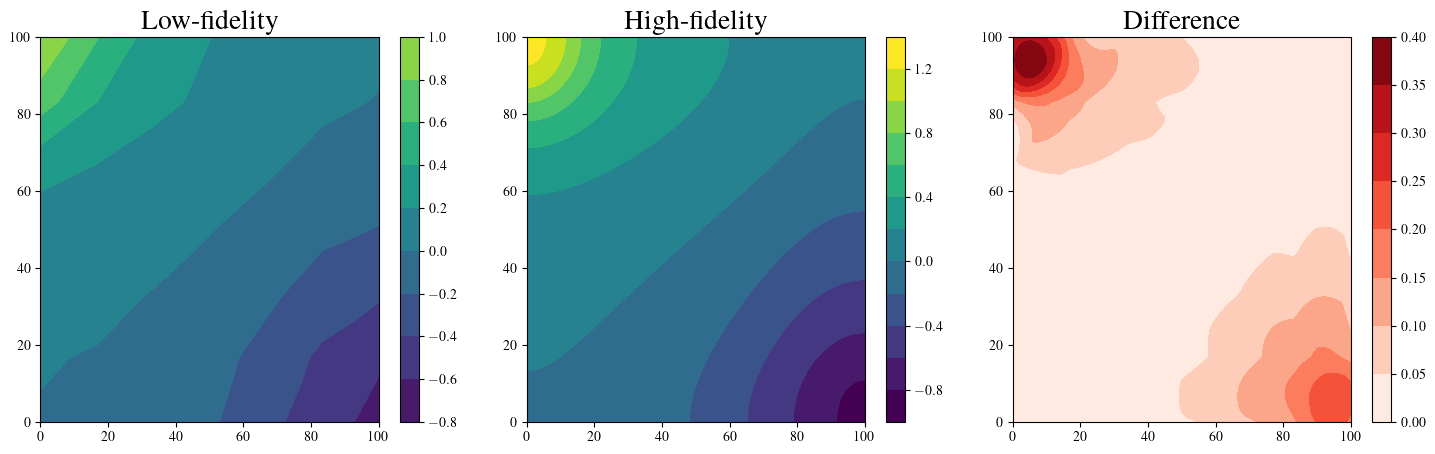

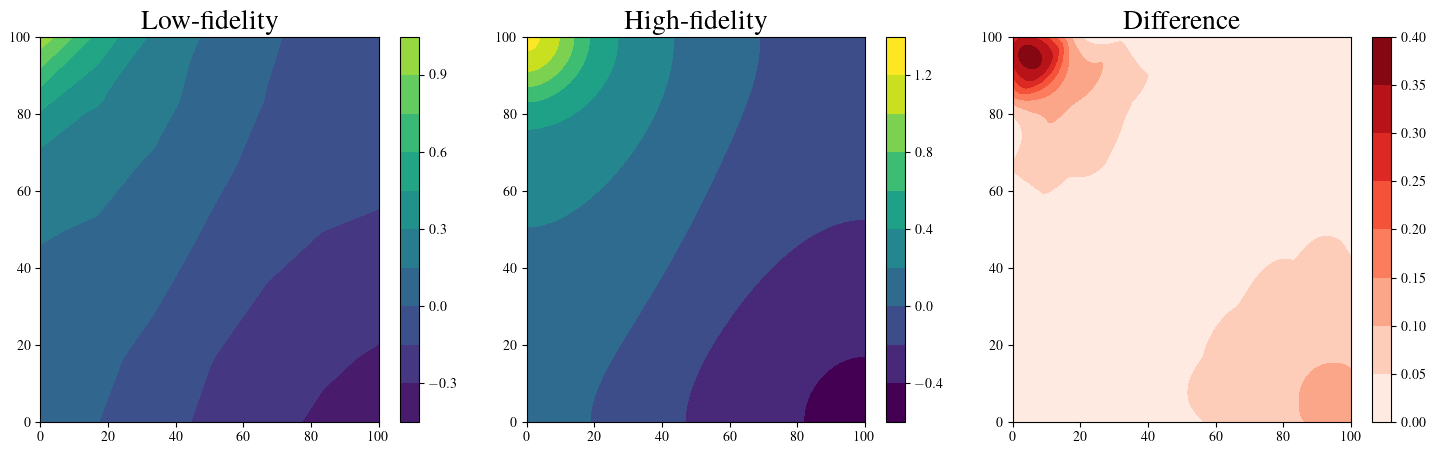

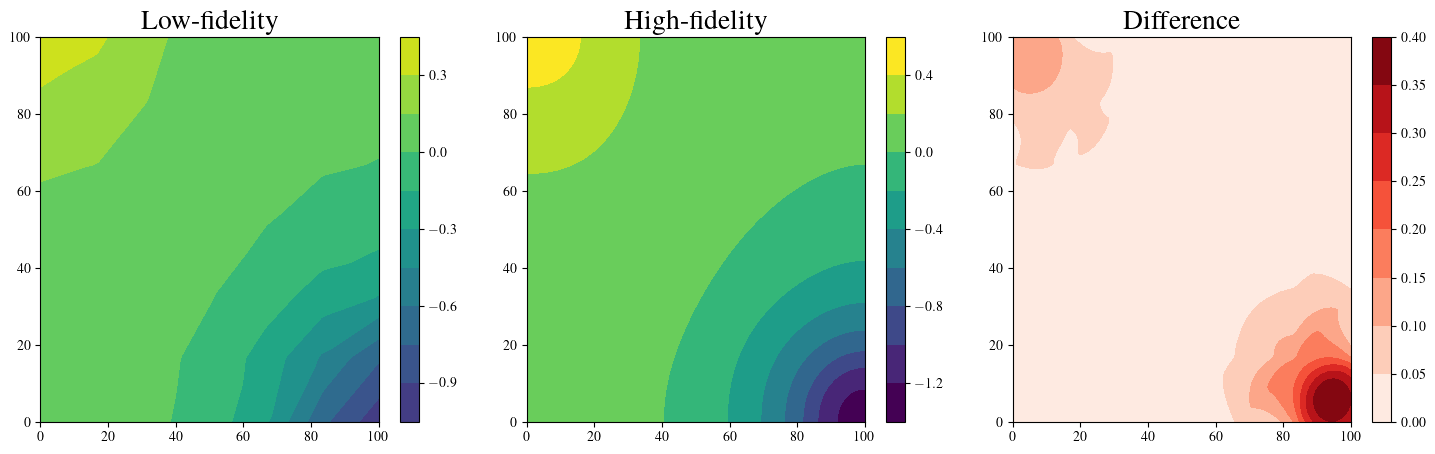

In [4]:
plot_data(x_LF, x_HF, dataset_name, n_samples=3)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

#### Perform spectral clustering

In [ ]:
import time as time

from specmf.utils import spectral_clustering


# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

t1 = time.time()
adjacency = g_LF.compute_adjacency()
t2 = time.time()
print(f"Time taken to compute adjacency matrix: {t2 - t1} seconds")

t1 = time.time()
graph_laplacian = g_LF.compute_graph_laplacian(adjacency)
t2 = time.time()
print(f"Time taken to compute graph Laplacian: {t2 - t1} seconds")

t1 = time.time()
eigvals, eigvecs = g_LF.laplacian_eig()
t2 = time.time()
print(f"Time taken to compute eigenvalues and eigenvectors: {t2 - t1} seconds")

t1 = time.time()
inds_centroids, labels = spectral_clustering(eigvecs, 100)
t2 = time.time()
print(f"Time taken to compute spectral clustering: {t2 - t1} seconds")

Time taken to compute adjacency matrix: 426.5573480129242 seconds
Time taken to compute graph Laplacian: 3.739434003829956 seconds
Time taken to compute eigenvalues and eigenvectors: 23.187992811203003 seconds
Time taken to compute spectral clustering: 5.750530004501343 seconds


In [11]:
import time as time

from specmf.utils import spectral_clustering


# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'k-nn',
    'k_nn': 500,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

# t1 = time.time()
# adjacency = g_LF.compute_adjacency()
# t2 = time.time()
# print(f"Time taken to compute adjacency matrix: {t2 - t1} seconds")

# t1 = time.time()
# graph_laplacian = g_LF.compute_graph_laplacian(adjacency)
# t2 = time.time()
# print(f"Time taken to compute graph Laplacian: {t2 - t1} seconds")

# t1 = time.time()
# eigvals, eigvecs = g_LF.laplacian_eig()
# t2 = time.time()
# print(f"Time taken to compute eigenvalues and eigenvectors: {t2 - t1} seconds")

# t1 = time.time()
# inds_centroids, labels = spectral_clustering(eigvecs, 100)
# t2 = time.time()
# print(f"Time taken to compute spectral clustering: {t2 - t1} seconds")

In [12]:
n_HF = 120
inds_train, labels = g_LF.cluster(n_HF)

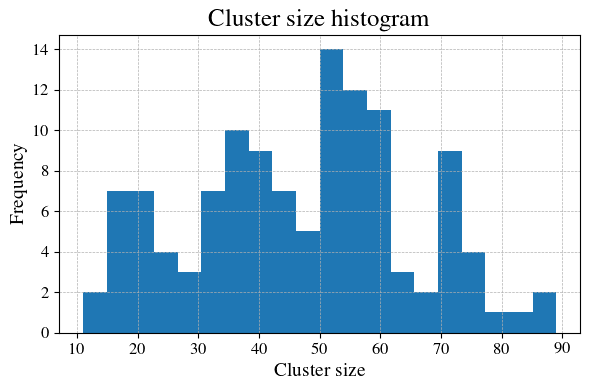

In [13]:
plot_cluster_size_hist(labels)

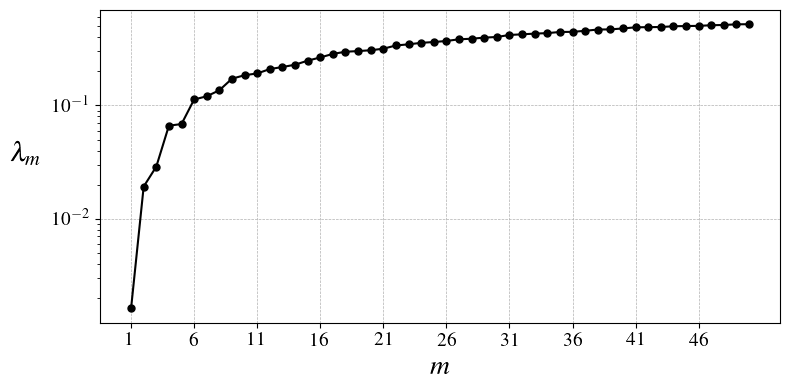

In [14]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Split high-fidelity data

In [15]:
n_samples = x_HF.shape[0]
inds_test = np.delete(np.arange(n_samples), inds_train)
x_HF_train = x_HF[inds_train, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(120, 10201) x_HF_test.shape=(5501, 10201)


#### Fit and train the model

In [16]:
fit_model = False

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'trunc',
    'spectrum_cutoff': 1200,
}
model = MultiFidelityModel(**model_config)

In [17]:
if fit_model:
    x_MF, C_phi, dPhi, loss_history, kappa_history = model.fit_transform(
        g_LF,
        x_HF_train,
        inds_train,
        maxiter=30,
        step_size=25,
        step_decay_rate=1.2,
        ftol=1e-7,
        verbose=False,
    )
    model.summary()
    plot_loss_and_kappa(loss_history, kappa_history)

else:
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent.parent / 'data/model_configs.yaml'
    model_config = load_model_config(yaml_file_path, dataset_name)

    model = MultiFidelityModel(**model_config)

    x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
    model.summary()

Model Configuration:
sigma              : 0.01
beta               : 2
kappa              : 0.1535
omega              : 415.1887641584857
method             : trunc
spectrum_cutoff    : 1200
tau                : 0.019227879592100677


Text(0.5, 1.0, 'Variance histogram for Darcy problem')

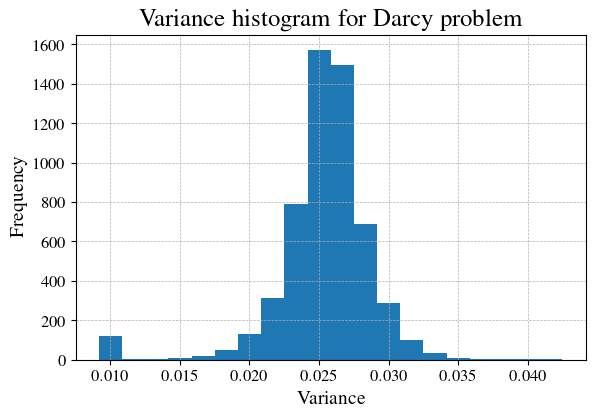

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram for Darcy problem", fontsize=18)

### Results

In [19]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test)

Mean relative L2 errors and percentage error drop
-------------------------------------------------
Error LF:   25.2 (5.39)
Error MF:   4.12 (2.3) 
[%] drop:   83.65%     


In [20]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative L2 errors and percentage error drop
-------------------------------------------------
Error LF:   25.2 (5.4)
Error MF:   4.04 (2.33)
[%] drop:   83.95%    


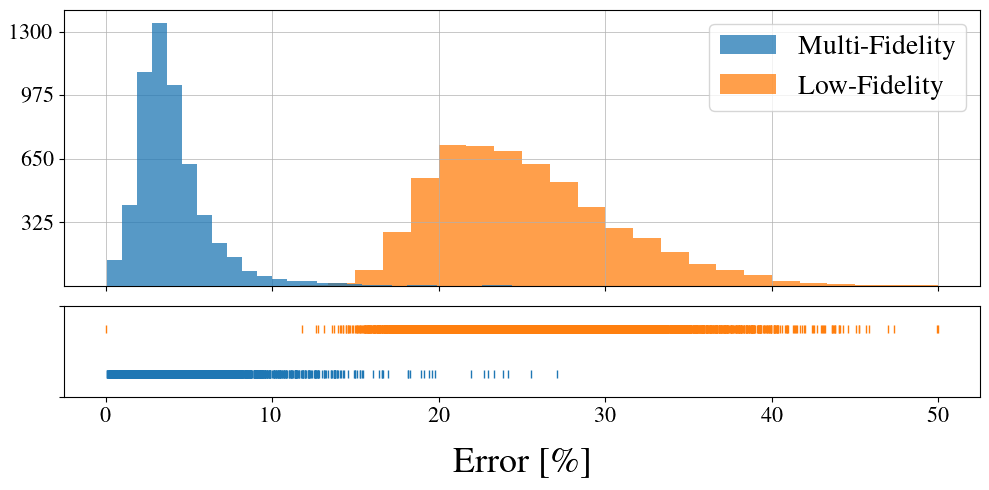

In [21]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=30, bins_MF=30, mask=None)

In [22]:
import os
data_path = "/Users/orazio/codes/spectral-multifidelity/data/"
K = np.load(os.path.join(data_path, "darcy/K.npy"))
K = K[:, :, mask]

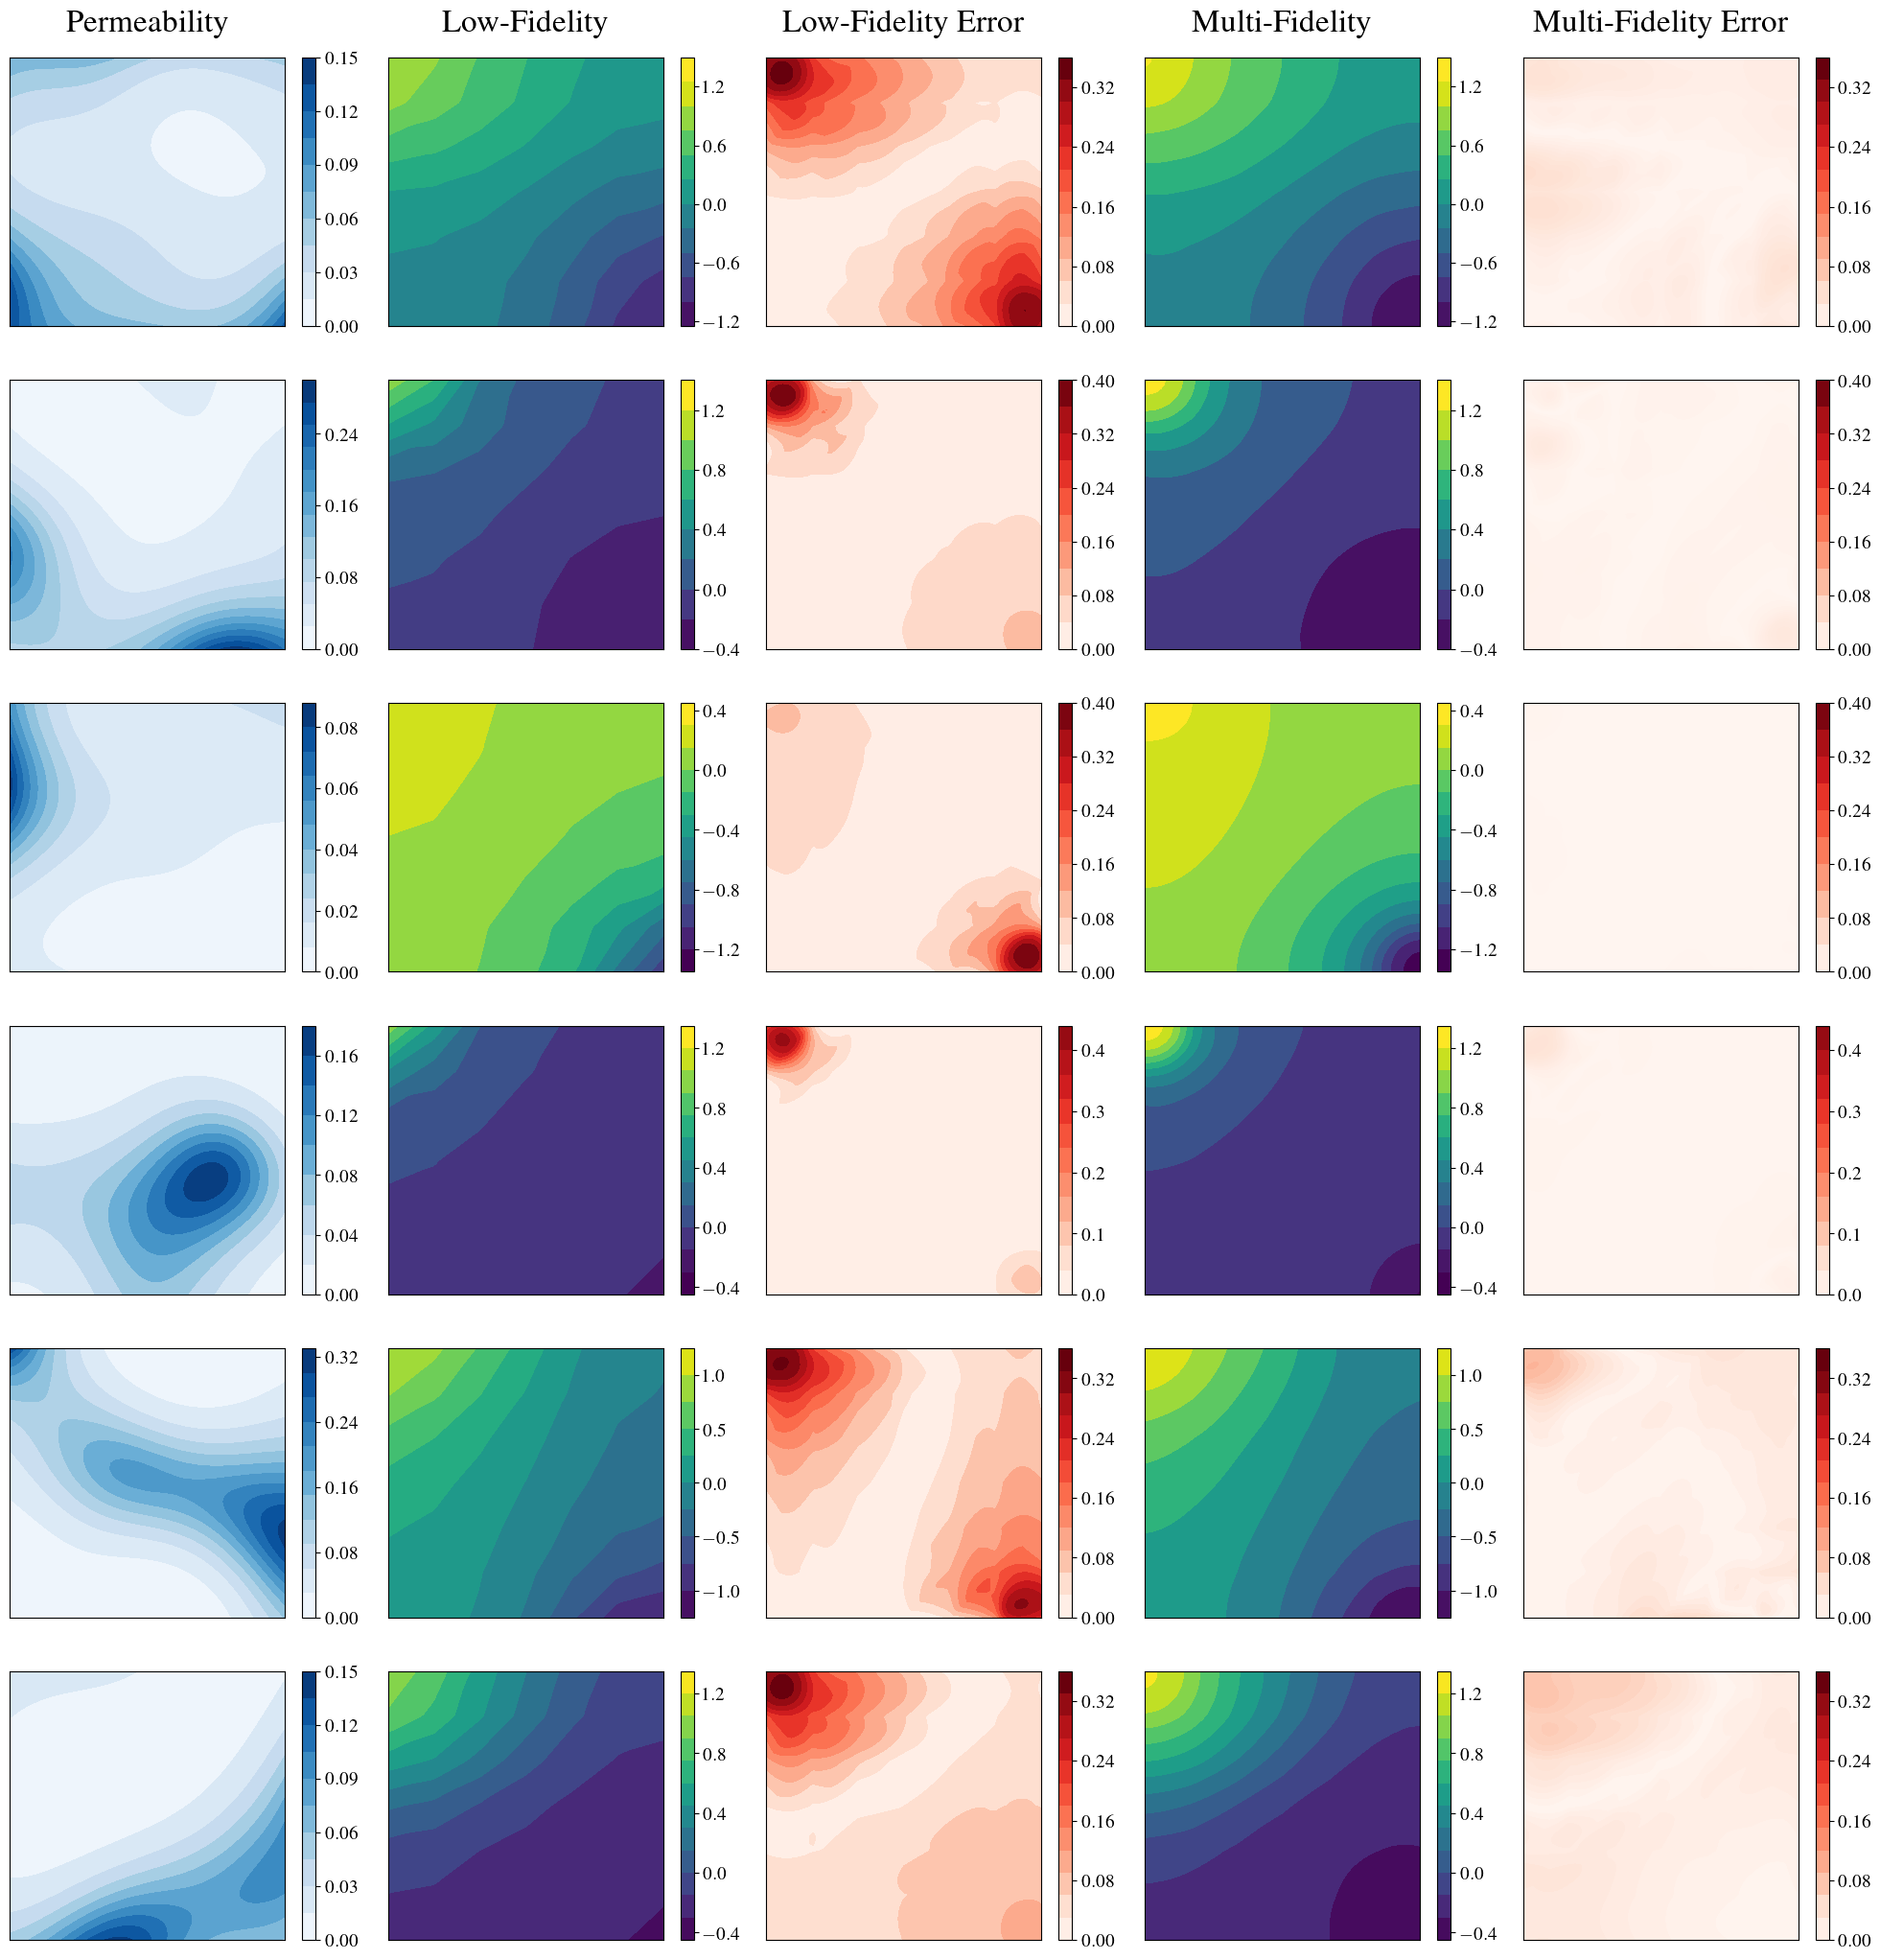

In [23]:
plot_mf_comparison(
    dataset_name=dataset_name,
    X_LF=x_LF,
    X_MF=x_MF,
    X_HF=x_HF,
    samples=[4059, 5505, 1131, 3367, 11, 194],
    input_field=K,
)

### Visualize uncertainty of multi-fidelity estimates

In [24]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [25]:
g_MF = Graph(data=x_MF, **graph_config)

In [26]:
_, eigevs = g_MF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [27]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=0.175,
    init='random', 
    random_state=42
).fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/specmf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/specmf/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP of Darcy Flow data')

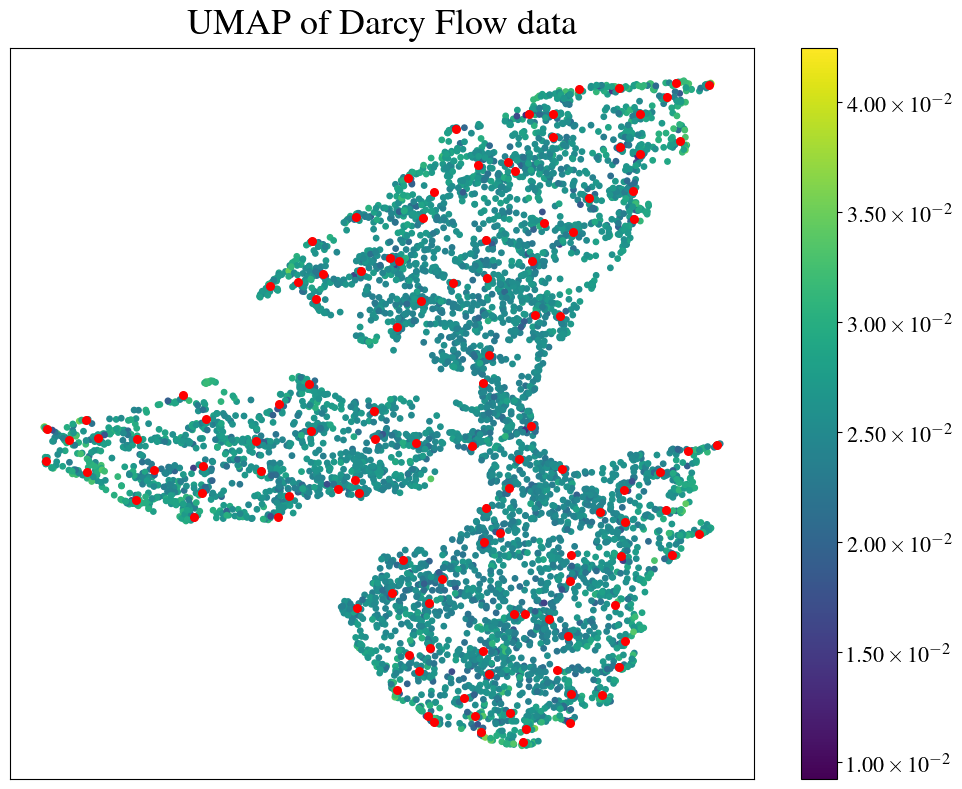

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, )
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Darcy Flow data', fontsize=26, pad=10)